In [1]:
%load_ext autoreload
%autoreload 2

import logging
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import tensor

import weight_formats.experiments as E

logging.basicConfig(level=logging.WARNING, force=True)
matplotlib.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False,
    "figure.figsize": (5, 3),
})

2025-07-09:21:21:53,051 INFO     [rouge_scorer.py:83] Using default tokenizer.
2025-07-09:21:21:53,802 INFO     [_client.py:1025] HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


In [3]:
runs = E.runs("20250630-qat-variants")
len(runs)

44

## Check correct format variants for main sweep

For Llama models, we have consistently the best `mode=asymmetric`, and best `block_size=64`, except for `element_bits=3`, in which case `block_size=128`. But the difference is close enough to use `block_size=64` everywhere.

In [ ]:
runs_prev = E.runs("20250506-results-main", progress=True)

query: 4680it [09:48,  7.95it/s]


In [51]:
def run_name(run: E.AttrDict) -> str:
    fmt = run.config.test.fmt
    name = ""
    name += {(None, None): "Tensor", (1, None): "Channel"}.get(tuple(fmt.block_shape), "Block")
    name += f"-{fmt.scaling.capitalize()}"
    if fmt.sparse_ratio:
        name += "+S"
    if fmt.compressor == "optimal":
        name += "+Z"
    return name

df = pd.DataFrame.from_records([
    dict(
        model=run.config.model.split("/")[-1],
        name=run_name(run),
        mode=run.config.test.fmt.args.get("mode"),
        block_size=run.config.test.fmt.block_shape[1],
        element_bits=run.config.test.fmt.element_bits,
        kl_div=tensor(run.summary.kl_div).mean().item(),
    )
    for run in runs_prev
    if run.config.model.startswith("meta-llama")
    and run.config.test.fmt.element_bits in [3, 4, 5]
    and run.config.test.fmt.sparse_ratio != 2**-7
    and not (run.config.test.fmt.element_family == "int" and run.config.test.fmt.compressor is None)
])

print("Best mode & block_size:")
display(df[df.name.isin(["Tensor-Rms+Z", "Tensor-Rms+S", "Block-Absmax", "Channel-Absmax", "Tensor-Absmax", "Tensor-Rms"])]
 .groupby(["model", "name", "element_bits"])
 .apply(lambda s: s.loc[s.kl_div.idxmin()], include_groups=False)
)

print("Difference in block_size performance:")
display(df[(df.name == "Block-Absmax") & (df["mode"] == "asymmetric")]
        .pivot(index=["name", "mode", "model", "element_bits"], columns="block_size", values="kl_div")
        )

Best mode & block_size:


mode  block_size     kl_div
model        name           element_bits                                   
Llama-3.1-8B Block-Absmax   3.0           asymmetric       128.0   1.219391
                            4.0           asymmetric        64.0   0.066668
                            5.0           asymmetric        64.0   0.016886
             Channel-Absmax 3.0           asymmetric         NaN   1.092230
                            4.0           asymmetric         NaN   0.134891
                            5.0           asymmetric         NaN   0.034743
             Tensor-Absmax  3.0           asymmetric         NaN   4.935936
                            4.0           asymmetric         NaN   2.097803
                            5.0           asymmetric         NaN   2.075373
             Tensor-Rms     3.0           asymmetric         NaN   8.969910
                            4.0            symmetric         NaN  11.872102
                            5.0            symmetric         NaN  11.112483
             Tensor-Rms+S   3.0           asymmetric         NaN   0.503273
                            4.0           asymmetric         NaN   0.094679
                            5.0           asymmetric         NaN   0.024820
             Tensor-Rms+Z   3.0                 None         NaN   0.206697
                            4.0                 None         NaN   0.052513
                            5.0                 None         NaN   0.014722
Llama-3.2-1B Block-Absmax   3.0           asymmetric       128.0   1.168824
                            4.0           asymmetric        64.0   0.109118
                            5.0           asymmetric        64.0   0.025545
             Channel-Absmax 3.0           asymmetric         NaN   1.845060
                            4.0           asymmetric         NaN   0.184122
                            5.0           asymmetric         NaN   0.045864
             Tensor-Absmax  3.0           asymmetric         NaN   4.223384
                            4.0           asymmetric         NaN   0.399268
                            5.0           asymmetric         NaN   0.193823
             Tensor-Rms     3.0           asymmetric         NaN   6.905794
                            4.0           asymmetric         NaN   4.337484
                            5.0           asymmetric         NaN   1.884206
             Tensor-Rms+S   3.0           asymmetric         NaN   1.169441
                            4.0           asymmetric         NaN   0.154258
                            5.0           asymmetric         NaN   0.033623
             Tensor-Rms+Z   3.0                 None         NaN   0.517288
                            4.0                 None         NaN   0.094430
                            5.0                 None         NaN   0.023133
Llama-3.2-3B Block-Absmax   3.0           asymmetric       128.0   0.715352
                            4.0           asymmetric        64.0   0.061154
                            5.0           asymmetric        64.0   0.016751
             Channel-Absmax 3.0           asymmetric         NaN   0.831055
                            4.0           asymmetric         NaN   0.114391
                            5.0           asymmetric         NaN   0.029046
             Tensor-Absmax  3.0           asymmetric         NaN   2.966360
                            4.0           asymmetric         NaN   0.504566
                            5.0           asymmetric         NaN   3.051093
             Tensor-Rms     3.0            symmetric         NaN   6.641873
                            4.0            symmetric         NaN   4.791363
                            5.0            symmetric         NaN   6.875432
             Tensor-Rms+S   3.0           asymmetric         NaN   0.474507
                            4.0           asymmetric         NaN   0.079104
                            5.0           asymmetric         NaN   0.022645
             Tensor-

Difference in block_size performance:


block_size                                            64.0      128.0
name         mode       model        element_bits                    
Block-Absmax asymmetric Llama-3.1-8B 3.0           1.273899  1.219391
                                     4.0           0.066668  0.081449
                                     5.0           0.016886  0.019888
                        Llama-3.2-1B 3.0           1.189428  1.168824
                                     4.0           0.109118  0.129002
                                     5.0           0.025545  0.029935
                        Llama-3.2-3B 3.0           0.772382  0.715352
                                     4.0           0.061154  0.071083
                                     5.0           0.016751  0.018766

## Formats (fig.1)

`tag: formats`

,variant_name,fmt,bits_per_param,valid_kl_div
0,dynamic,"4b-int+Zoptimal{*,*:BFLOAT16:rms:search}",4.009530,0.031919
1,dynamic,"4b-t(mode=asymmetric){*,*:BFLOAT16:rms:search}...",4.047554,0.048446
2,dynamic,"4b-t(mode=asymmetric){1,64:BFLOAT16:absmax:sea...",4.250666,0.038778
3,dynamic,"4b-t(mode=asymmetric){1,*:BFLOAT16:absmax:search}",4.007219,0.057245
4,dynamic,"4b-t(mode=asymmetric){*,*:BFLOAT16:absmax:search}",4.000681,0.079792
5,dynamic,"4b-t(mode=asymmetric){*,*:BFLOAT16:rms:search}",4.000681,0.068136
6,parameter,"4b-int+Zoptimal{*,*:BFLOAT16:rms:search}",5.640904,0.014691
7,parameter,"4b-t(mode=asymmetric){*,*:BFLOAT16:rms:search}...",4.047554,0.055065
8,parameter,"4b-t(mode=asymmetric){1,64:BFLOAT16:absmax:sea...",4.250666,0.038905
9,parameter,"4b-t(mode=asymmetric){1,*:BFLOAT16:absmax:search}",4.007219,0.056869


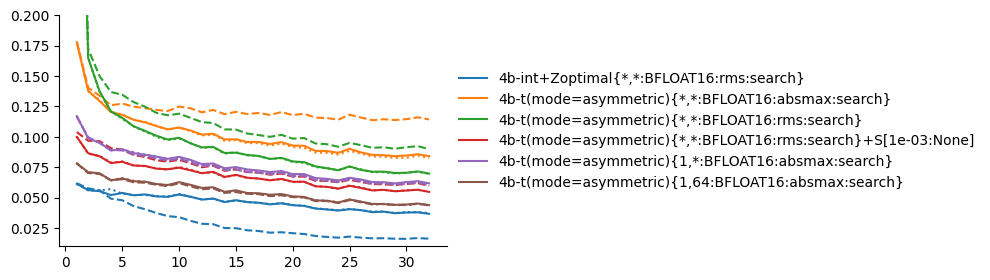

In [4]:
df = pd.DataFrame.from_records([
    dict(
        fmt=run.config.test.get("fmt_str", "bfloat16"),
        scaling_mode=run.config.test.get("scaling_mode"),
        trainable_centroids=bool(run.config.opt.lr_modifiers.centroids),
        bits_per_param=run.summary.bits_per_param,
        valid_kl_div=run.summary.valid_kl_div,
        step_log=torch.arange(len(run.summary.train.loss)).tolist(),
        loss_log=run.summary.train.loss,
        bits_per_param_log=run.summary.train.bits_per_param,
    )
    for run in runs
    if run.meta.status == "finished"
    and run.config.tag == "formats"
])
df["variant_name"] = df.apply(lambda g: g.scaling_mode + ("_centroids" if g.trainable_centroids else ""), axis=1)
display(df[["variant_name", "fmt", "bits_per_param", "valid_kl_div"]])

_, ax = plt.subplots()
for (fmt, gg), color in zip(df.groupby("fmt"), sns.color_palette()):
    for _, g in gg.iterrows():
        ax.plot(g.loss_log, label=g.fmt if g.variant_name=="dynamic" else None,
                ls=dict(dynamic="-", parameter="--", dynamic_centroids=":")[g.variant_name], color=color)
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_ylim((0.01, 0.2));

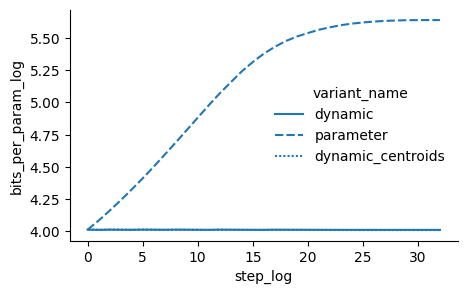

In [4]:
# Cheating!
d = df[df.fmt == "4b-int+Zoptimal{*,*:BFLOAT16:rms:search}"].explode(["step_log", "bits_per_param_log"])
sns.lineplot(d, y="bits_per_param_log", x="step_log", style="variant_name");

In [5]:
df = pd.DataFrame.from_records([
    dict(
        fmt=run.config.test.get("fmt_str", "bfloat16"),
        bits_per_param=run.summary.bits_per_param,
        neg_valid_kl_div=-run.summary.valid_kl_div,
        **{k: v.primary_score for k, v in run.summary.downstream.items()},
    )
    for run in runs
    if run.meta.status == "finished"
    and run.config.tag == "formats"
    and run.config.test.scaling_mode == "dynamic"
    and run.config.opt.lr_modifiers.centroids == 0
])
df.set_index(["fmt", "bits_per_param"]).sort_values("neg_valid_kl_div", ascending=False).style.background_gradient()

,,neg_valid_kl_div,socialiqa:mc,hellaswag,openbookqa:mc,arc_challenge:mc,arc_easy:mc,csqa:mc,piqa,winogrande,boolq
fmt,bits_per_param,,,,,,,,,,
"4b-int+Zoptimal{*,*:BFLOAT16:rms:search}",4.009530,-0.031919,0.429376,0.646000,0.396000,0.307692,0.538596,0.377559,0.739935,0.595107,0.631498
"4b-t(mode=asymmetric){1,64:BFLOAT16:absmax:search}",4.250666,-0.038778,0.441658,0.649000,0.376000,0.344482,0.505263,0.375102,0.745375,0.595896,0.628440
"4b-t(mode=asymmetric){*,*:BFLOAT16:rms:search}+S[1e-03:None]",4.047554,-0.048446,0.427329,0.633000,0.386000,0.321070,0.491228,0.381654,0.742655,0.593528,0.614067
"4b-t(mode=asymmetric){1,*:BFLOAT16:absmax:search}",4.007219,-0.057245,0.393552,0.642000,0.324000,0.280936,0.401754,0.315315,0.729597,0.584057,0.628440
"4b-t(mode=asymmetric){*,*:BFLOAT16:rms:search}",4.000681,-0.068136,0.326510,0.351000,0.286000,0.257525,0.249123,0.199836,0.559304,0.511444,0.505505
"4b-t(mode=asymmetric){*,*:BFLOAT16:absmax:search}",4.000681,-0.079792,0.406346,0.613000,0.340000,0.311037,0.428070,0.296478,0.735038,0.578532,0.586850


## Direct Cast

`tag: direct-cast`

In [ ]:
df = pd.DataFrame.from_records([
    dict(
        fmt=run.config.test.get("fmt_str", "bfloat16"),
        bits_per_param=run.summary.bits_per_param,
        neg_valid_kl_div=-run.summary.valid_kl_div,
        **{k: v.primary_score for k, v in run.summary.downstream.items()},
    )
    for run in runs
    if run.meta.status == "finished"
    and run.config.tag == "direct-cast"
])
df.set_index(["fmt", "bits_per_param"]).sort_values("neg_valid_kl_div", ascending=False).style.background_gradient()

,,neg_valid_kl_div,socialiqa:mc,hellaswag,openbookqa:mc,arc_challenge:mc,arc_easy:mc,csqa:mc,piqa,winogrande,boolq
fmt,bits_per_param,,,,,,,,,,
bfloat16,16.000000,-0.001158,0.467758,0.654000,0.428000,0.311037,0.549123,0.416871,0.747008,0.602999,0.642202
"4b-int+Zoptimal{*,*:BFLOAT16:rms:search}",4.011425,-0.094753,0.412487,0.636000,0.356000,0.307692,0.512281,0.385749,0.742655,0.598264,0.595107
"4b-t(mode=asymmetric){1,64:BFLOAT16:absmax:search}",4.250666,-0.109417,0.398158,0.635000,0.354000,0.311037,0.438596,0.380016,0.735038,0.588792,0.626300
"4b-t(mode=asymmetric){*,*:BFLOAT16:rms:search}+S[1e-03:None]",4.047554,-0.154842,0.429376,0.631000,0.352000,0.354515,0.477193,0.336609,0.733406,0.588003,0.634557
"4b-t(mode=asymmetric){1,*:BFLOAT16:absmax:search}",4.007219,-0.184835,0.394063,0.620000,0.322000,0.304348,0.392982,0.309582,0.722524,0.584057,0.628135
"4b-t(mode=asymmetric){*,*:BFLOAT16:absmax:search}",4.000681,-0.406652,0.392528,0.586000,0.336000,0.244147,0.394737,0.299754,0.720892,0.561168,0.568196
"4b-t(mode=asymmetric){*,*:BFLOAT16:rms:search}",4.000681,-4.388420,0.342886,0.266000,0.250000,0.264214,0.245614,0.201474,0.551687,0.486188,0.392049


## Scale training variants

`tag: v0`

In [4]:
def get_name(s: pd.Series) -> str:
    name = s.scaling_mode
    if s.scaling_mode == "parameter" and not s.trainable_scale:
        name = f"{name}-frozen"
    if s.clip_gradient:
        name = f"{name}-clip"
    return name

df = pd.DataFrame.from_records([
    dict(
        scaling_mode=run.config.test.scaling_mode,
        clip_gradient=run.config.test.clip_gradient,
        trainable_scale=bool(run.config.opt.lr_modifiers.scale),
        lr=run.config.opt.lr,
        valid_kl_div=run.summary.valid_kl_div,
        loss=run.summary.train.loss[1:],
        step=(run.config.train.log_interval * (1+torch.arange(len(run.summary.train.loss[1:])))).tolist(),
        downstream={k: v.primary_score for k, v in run.summary.downstream.items()},
    )
    for run in runs
    if run.meta.status == "finished"
    and run.config.tag == "v0"
])
df["name"] = df.apply(get_name, axis=1)
display(df[:2])

,scaling_mode,clip_gradient,trainable_scale,lr,valid_kl_div,loss,step,downstream,name
0,parameter,False,True,0.000004,0.064638,"[0.12691207, 0.099900715, 0.095124118, 0.08788...","[128.0, 256.0, 384.0, 512.0, 640.0, 768.0, 896...","{'socialiqa:mc': 0.4037871, 'hellaswag': 0.637...",parameter
1,parameter,True,True,0.000004,0.057955,"[0.1267622, 0.099840418, 0.095064193, 0.087420...","[128.0, 256.0, 384.0, 512.0, 640.0, 768.0, 896...","{'socialiqa:mc': 0.42374616, 'hellaswag': 0.63...",parameter-clip


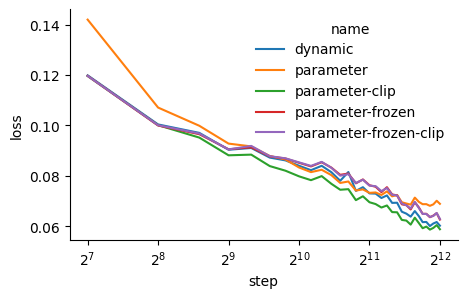

In [10]:
ax = sns.lineplot(data=df.groupby("name").apply(lambda g: g.loc[g.valid_kl_div.idxmin()], include_groups=False).explode(["loss", "step"]),
                  y="loss", x="step", hue="name")
ax.set_xscale("log", base=2)

(0.052, 0.075)

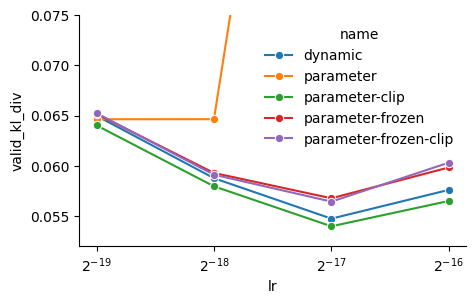

In [11]:
ax = sns.lineplot(data=df.sort_values("name"), y="valid_kl_div", x="lr", hue="name", marker="o")
ax.set_xscale("log", base=2)
ax.set_ylim((0.052, 0.075))

In [7]:
(df.groupby("name").apply(lambda g: g.loc[g.valid_kl_div.idxmin()], include_groups=False)
 [["valid_kl_div", "downstream"]]
 .pipe(lambda d: pd.concat([d.assign(neg_valid_kl_div=-d.valid_kl_div)[["neg_valid_kl_div"]], d["downstream"].apply(pd.Series)], axis=1))
 .sort_values("neg_valid_kl_div", ascending=False)
 .style.background_gradient()
)

,neg_valid_kl_div,socialiqa:mc,hellaswag,openbookqa:mc,arc_challenge:mc,arc_easy:mc,csqa:mc,piqa,winogrande,boolq
name,,,,,,,,,,
parameter-clip,-0.053973,0.438076,0.635000,0.392000,0.317726,0.521053,0.378378,0.747552,0.595107,0.637309
dynamic,-0.054736,0.434493,0.637000,0.382000,0.290970,0.457895,0.320229,0.749728,0.591949,0.626606
parameter-frozen-clip,-0.056432,0.422211,0.637000,0.404000,0.331104,0.485965,0.333333,0.742655,0.600631,0.582875
parameter-frozen,-0.056763,0.447288,0.633000,0.424000,0.347826,0.459649,0.309582,0.739935,0.607735,0.603670
parameter,-0.064631,0.417093,0.639000,0.368000,0.314381,0.468421,0.334152,0.737214,0.580110,0.618043
